In [ ]:
!pip install wandb

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, random_split, DataLoader, Subset
import matplotlib.pyplot as plt
import wandb
import random


In [ ]:
random.seed(42)


In [ ]:
class CNN(nn.Module):
    def __init__(self, cnn_nr=2, kernel_sizes=[], channels=[], dense_nr=2, dense_sizes=[], dropout_cnn = [], dropout_dense = [], use_batchnorm = False):
        super(CNN, self).__init__()

        self.cnn_layers = nn.ModuleList()
        self.dense_layers = nn.ModuleList()

        # CNN
        for nr in range(cnn_nr):
            kernel = kernel_sizes[nr]
            in_channels = channels[nr]
            out_channels = channels[nr + 1]
            padding = (kernel - 1) // 2
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel, padding=padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(dropout_cnn[nr]) if len(dropout_cnn) > nr else nn.Identity()
            )

            self.cnn_layers.append(block)

        ## Linear Dense
        for nr in range(dense_nr):
            in_features = dense_sizes[nr]
            out_features = dense_sizes[nr + 1]
            block = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.ReLU() if nr != dense_nr - 1 else nn.Identity(),
                nn.BatchNorm1d(out_features) if use_batchnorm else nn.Identity(),
                nn.Dropout(dropout_dense[nr]) if len(dropout_dense) > nr else nn.Identity()
            )
            self.dense_layers.append(block)

    def forward(self, x):
        for layer in self.cnn_layers:
            x = layer(x)

        x = nn.Flatten()(x)

        for layer in self.dense_layers:
            x = layer(x)
        return x

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        ## CNN
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        ## Linear Dense
        self.dense = nn.Sequential(
            nn.Linear(256 * 5 * 5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 102)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = torch.flatten(x, 1)
        x = self.dense(x)
        return x

In [ ]:
def load_data(limit_train=1.0, augmentation = False, batch_size = 16):
    transform_actions = [
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]

    if augmentation:
        transform_actions.extend([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomAffine(
                degrees=10,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1)
            ),
        ])

    transform = transforms.Compose(transform_actions)
    train = torchvision.datasets.Flowers102(root='./data', split="train", download=True, transform=transform)
    test = torchvision.datasets.Flowers102(root='./data', split="test", download=True, transform=transform)
    val = torchvision.datasets.Flowers102(root='./data', split="val", download=True, transform=transform)
    train_size = len(train)
    test_size = len(test)

    ## limit
    if 0 < limit_train < 1.0:
        train_len = int(len(train) * limit_train)
        indices = random.sample(list(range(len(train))), train_len)
        train = Subset(train, indices)

    ## move from test to train
    elif limit_train > 1.0:
        train_extra_len = int(len(train) * (limit_train - 1.0))

        indices = random.sample(list(range(len(test))), train_extra_len)
        extra_train = Subset(test, indices)

        train = ConcatDataset([train, extra_train])
        remaining_indices = list(set(range(len(test))) - set(indices))
        test = Subset(test, remaining_indices)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size)
    test_loader = DataLoader(test, batch_size=batch_size)

    return train_loader, val_loader, test_loader


In [ ]:
def train_model(model, train_loader, val_loader, epoch=30, lr=0.01, early_stop = 4, optimizer = "SGD", project_name = "", run_name = "", model_name = "model"):
    def plot_history(train_losses, val_losses):
        epochs = list(range(len(train_losses)))
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, train_losses, marker='o', label='Train Loss')
        plt.plot(epochs, val_losses, marker='s', label='Validation Loss')
        plt.title('Avg loss over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    run = wandb.init(project=project_name, name=run_name,
    config = {
        "lr": lr,
        "epoch": epoch,
        "optimizer": optimizer,
    })

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.to(device)

    loss_fun = nn.CrossEntropyLoss(reduction="none")
    if optimizer == "Adam":
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer == "SGD":
      optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_history = []
    val_history = []
    early_stop_iter = early_stop
    for nr in range(epoch):
        model.train()
        correct, loss_total = 0, 0
        for X, y in train_loader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            predicted = model(X)
            loss = loss_fun(predicted, y)
            correct += (predicted.argmax(dim=1) == y).sum().item()
            loss_total += loss.sum().item()
            loss.mean().backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_train_loss = loss_total / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset) * 100

        model.eval()
        correct, loss_total = 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                predicted = model(X)
                loss = loss_fun(predicted, y)
                correct += (predicted.argmax(dim=1) == y).sum().item()
                loss_total += loss.sum().item()

        avg_val_loss = loss_total / len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset) * 100

        train_history.append(avg_train_loss)
        val_history.append(avg_val_loss)

        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "epoch": nr
        })

        print(f"Epoch {nr+1}/{epoch} | Train Loss: {avg_train_loss} | Val Loss: {avg_val_loss}")


        ## early stopping
        if len(val_history) > 2 and val_history[-1] >= val_history[-2]:
          early_stop_iter -= 1
          if early_stop_iter == 0:
            print(f"Early stopping")
            break
        else:
          early_stop_iter = early_stop

    torch.save(model.state_dict(), model_name + ".pth")
    run.save(model_name +".pth")
    run.finish()

    plot_history(train_history, val_history)


In [ ]:
def get_acc(model, test_loader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  correct = 0
  total = 0
  model.eval()

  with torch.no_grad():
      for X, y in test_loader:

          X, y = X.to(device), y.to(device)

          predicted = torch.argmax(model(X), dim=1)
          correct += (predicted == y).sum().item()
          total += y.size(0)

  accuracy = correct / total * 100
  return accuracy

In [ ]:
test_model = lambda : CNN(3, [3,3,3], [3, 32, 64, 128], 2, [128*28*28, 256, 102])


## Train dataset size impact

epoch,▁▂▂▃▄▅▅▆▇▇█
train_acc,▄▁▄▅▆▅▅▇███
train_loss,█▇▆▆▅▄▄▃▂▂▁
val_acc,▁▃▃▅▅▆▄▅▆▆█
val_loss,█▇▇▆▅▅▄▃▂▂▁
epoch,10
train_acc,1.86275
train_loss,4.62273
val_acc,1.76471
val_loss,4.62357


Epoch 1/30 | Train Loss: 4.62693302304137 | Val Loss: 4.625285212198893
Epoch 2/30 | Train Loss: 4.611763243581734 | Val Loss: 4.625479963714001
Epoch 3/30 | Train Loss: 4.597552972681382 | Val Loss: 4.626410330978095
Epoch 4/30 | Train Loss: 4.580282099106732 | Val Loss: 4.628910969752892
Epoch 5/30 | Train Loss: 4.552279995936973 | Val Loss: 4.635002248427448
Epoch 6/30 | Train Loss: 4.521141706728468 | Val Loss: 4.649569926542394
Epoch 7/30 | Train Loss: 4.468562649745567 | Val Loss: 4.684872862871956
Early stopping


epoch,▁▂▃▅▆▇█
train_acc,▁██████
train_loss,█▇▇▆▅▃▁
val_acc,█▁▁▁▁▁▁
val_loss,▁▁▁▁▂▄█
epoch,6
train_acc,3.92157
train_loss,4.46856
val_acc,0.98039
val_loss,4.68487


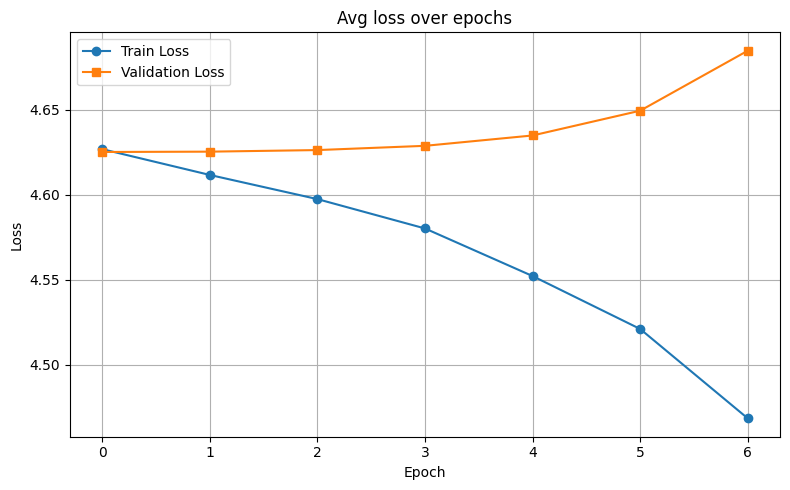

Epoch 1/30 | Train Loss: 4.626582014794443 | Val Loss: 4.6253794127819585
Epoch 2/30 | Train Loss: 4.6138449276194855 | Val Loss: 4.625968660092822
Epoch 3/30 | Train Loss: 4.601698108747894 | Val Loss: 4.6275627697215365
Epoch 4/30 | Train Loss: 4.586633364359538 | Val Loss: 4.631409461825502
Epoch 5/30 | Train Loss: 4.566556051665661 | Val Loss: 4.639858440324372
Epoch 6/30 | Train Loss: 4.540934936673033 | Val Loss: 4.6596286399691715
Epoch 7/30 | Train Loss: 4.515363132252412 | Val Loss: 4.686842593024759
Early stopping


epoch,▁▂▃▅▆▇█
train_acc,▁█████▁
train_loss,█▇▆▅▄▃▁
val_acc,▁▁▁▁▁█▁
val_loss,▁▁▁▂▃▅█
epoch,6
train_acc,0.98039
train_loss,4.51536
val_acc,0.98039
val_loss,4.68684


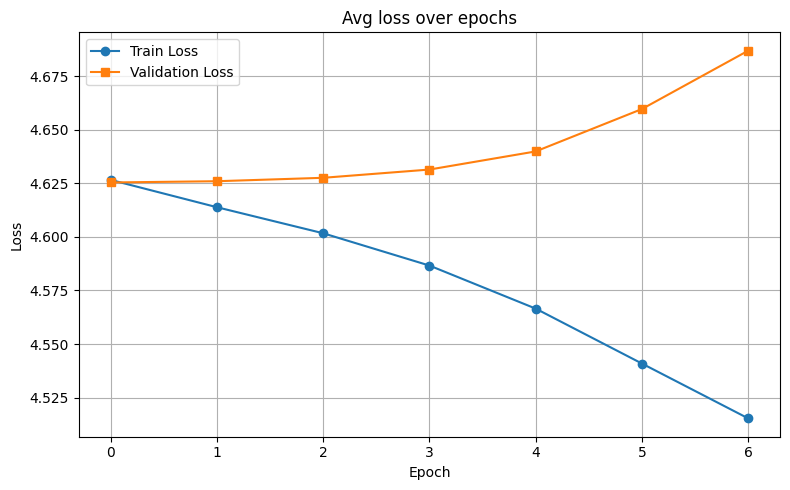

Epoch 1/30 | Train Loss: 4.6288463068943395 | Val Loss: 4.625132347555722
Epoch 2/30 | Train Loss: 4.617036946614584 | Val Loss: 4.6263709049598845
Epoch 3/30 | Train Loss: 4.606644409778071 | Val Loss: 4.629944244085574
Epoch 4/30 | Train Loss: 4.598032513786765 | Val Loss: 4.635757850198185
Epoch 5/30 | Train Loss: 4.58809856339997 | Val Loss: 4.6402189366957725
Epoch 6/30 | Train Loss: 4.57636744929295 | Val Loss: 4.648320788963169
Epoch 7/30 | Train Loss: 4.564894328397863 | Val Loss: 4.649395385442996
Early stopping


epoch,▁▂▃▅▆▇█
train_acc,▁▄▃▄▇█▇
train_loss,█▇▆▅▄▂▁
val_acc,▁▁▁▁█▅▂
val_loss,▁▁▂▄▅██
epoch,6
train_acc,2.15686
train_loss,4.56489
val_acc,1.07843
val_loss,4.6494


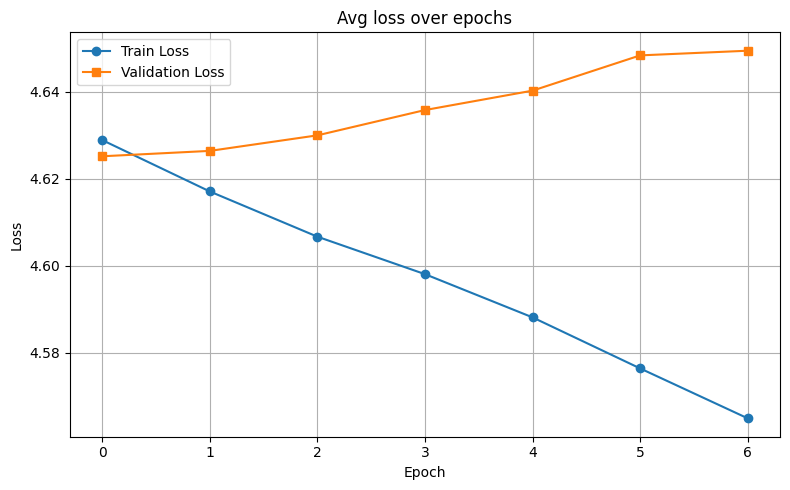

Epoch 1/30 | Train Loss: 4.627070426940918 | Val Loss: 4.622936375935873
Epoch 2/30 | Train Loss: 4.622388260037291 | Val Loss: 4.6199068106857
Epoch 3/30 | Train Loss: 4.6165877697514555 | Val Loss: 4.615098093070236
Epoch 4/30 | Train Loss: 4.607237077226825 | Val Loss: 4.605204627093147
Epoch 5/30 | Train Loss: 4.5909548179776065 | Val Loss: 4.585854982862285
Epoch 6/30 | Train Loss: 4.554181977814319 | Val Loss: 4.536086542466108
Epoch 7/30 | Train Loss: 4.461430044735179 | Val Loss: 4.421697029412962
Epoch 8/30 | Train Loss: 4.278951972138648 | Val Loss: 4.260608142030005
Epoch 9/30 | Train Loss: 4.103472471237183 | Val Loss: 4.144666181826124
Epoch 10/30 | Train Loss: 3.888092990015067 | Val Loss: 4.151574546215581
Epoch 11/30 | Train Loss: 3.6850421101439235 | Val Loss: 4.091961692361271
Epoch 12/30 | Train Loss: 3.4168839828640807 | Val Loss: 4.111541134703393
Epoch 13/30 | Train Loss: 3.1508134439879774 | Val Loss: 4.041483587377211
Epoch 14/30 | Train Loss: 2.8428103479684568

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▇▇███████
train_loss,███████▇▇▇▇▆▆▅▅▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁
val_acc,▁▂▂▂▂▂▂▂▃▃▄▄▅▆▅▅▆▆▇▆▇▇▇▇▇█████
val_loss,▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▂▃▃▃▃▄▆▅▇▆▆▇▇██
epoch,29
train_acc,100
train_loss,0.00379
val_acc,12.35294
val_loss,7.81933


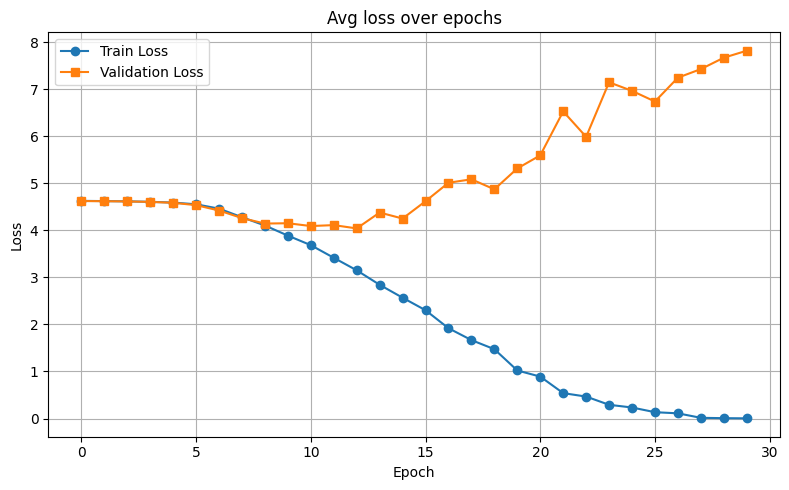

Epoch 1/30 | Train Loss: 4.629399325800877 | Val Loss: 4.621734312468884
Epoch 2/30 | Train Loss: 4.621166491040997 | Val Loss: 4.616235560996859
Epoch 3/30 | Train Loss: 4.6127565870098035 | Val Loss: 4.605577150980632
Epoch 4/30 | Train Loss: 4.593466631571451 | Val Loss: 4.579159665575214
Epoch 5/30 | Train Loss: 4.549941021788354 | Val Loss: 4.521758098228305
Epoch 6/30 | Train Loss: 4.4525278390622605 | Val Loss: 4.404065809062883
Epoch 7/30 | Train Loss: 4.261683299494725 | Val Loss: 4.313896560668946
Epoch 8/30 | Train Loss: 4.0526365803737265 | Val Loss: 4.117622682160023
Epoch 9/30 | Train Loss: 3.8510931538600546 | Val Loss: 4.088235533471201
Epoch 10/30 | Train Loss: 3.6307857139437805 | Val Loss: 4.110498880872539
Epoch 11/30 | Train Loss: 3.394398348939185 | Val Loss: 4.455511100619447
Epoch 12/30 | Train Loss: 3.1876281139897364 | Val Loss: 4.114058905956792
Epoch 13/30 | Train Loss: 2.8999640146891275 | Val Loss: 4.356353464313582
Epoch 14/30 | Train Loss: 2.638261583739

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇██████
train_loss,██████▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
val_acc,▁▁▁▁▂▂▃▄▄▄▄▅▆▅▆▇▅▇▆▅▆▄▇▇▆█▇█▇▇
val_loss,▂▂▂▂▂▂▁▁▁▁▂▁▁▂▂▂▃▃▄▄▄▇▄▅▄▆▆▇██
epoch,29
train_acc,100
train_loss,0.0037
val_acc,12.35294
val_loss,8.3696


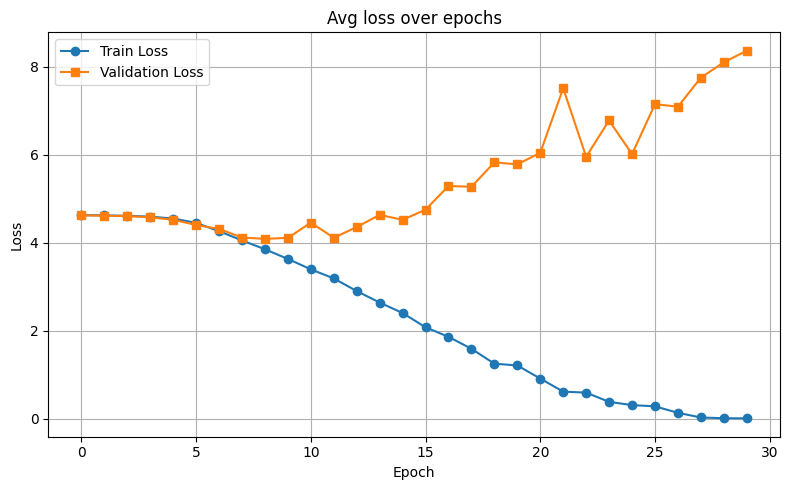

Epoch 1/30 | Train Loss: 4.626440065372994 | Val Loss: 4.623450739243451
Epoch 2/30 | Train Loss: 4.62236854821468 | Val Loss: 4.620655587140251
Epoch 3/30 | Train Loss: 4.617143198981796 | Val Loss: 4.6152529847388175
Epoch 4/30 | Train Loss: 4.607310063509501 | Val Loss: 4.60294220868279
Epoch 5/30 | Train Loss: 4.5820606478100805 | Val Loss: 4.564334734748392
Epoch 6/30 | Train Loss: 4.501582080968949 | Val Loss: 4.434620640324611
Epoch 7/30 | Train Loss: 4.303066286412985 | Val Loss: 4.305997863470339
Epoch 8/30 | Train Loss: 4.104505212991236 | Val Loss: 4.1531385646146886
Epoch 9/30 | Train Loss: 3.8852243680790224 | Val Loss: 4.164166570177265
Epoch 10/30 | Train Loss: 3.641955652494267 | Val Loss: 4.340070500093348
Epoch 11/30 | Train Loss: 3.3719102262183474 | Val Loss: 4.164950011758243
Epoch 12/30 | Train Loss: 3.140126728173269 | Val Loss: 4.376151649624694
Epoch 13/30 | Train Loss: 2.831984765590066 | Val Loss: 4.385794643327301
Epoch 14/30 | Train Loss: 2.487065616242728 

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▁▁▁▁▁▁▁▁▂▂▂▃▃▄▅▅▆▆▇▇▇████████
train_loss,███████▇▇▇▆▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▂▂▂▃▂▃▄▄▄▃▅▅▄▅▄▃▆▅█▆▆█▇██
val_loss,▂▂▂▂▂▁▁▁▁▁▁▁▁▂▄▂▂▃▂▆█▄▅▃▄▅▃▄▄▄
epoch,29
train_acc,100
train_loss,0.00283
val_acc,20.58824
val_loss,6.65597


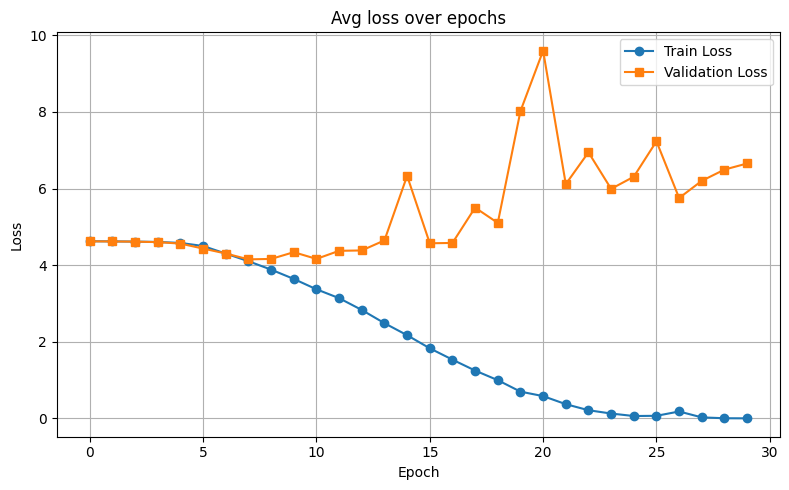

Epoch 1/30 | Train Loss: 4.621659262663399 | Val Loss: 4.626229379691329
Epoch 2/30 | Train Loss: 4.609706719093073 | Val Loss: 4.630136796539905
Epoch 3/30 | Train Loss: 4.598633889590992 | Val Loss: 4.633570697260838
Epoch 4/30 | Train Loss: 4.58537412655899 | Val Loss: 4.6252955829395965
Epoch 5/30 | Train Loss: 4.561599517024421 | Val Loss: 4.604506084965725
Epoch 6/30 | Train Loss: 4.465798426609413 | Val Loss: 4.444196046567431
Epoch 7/30 | Train Loss: 4.229257967581157 | Val Loss: 4.247308547824037
Epoch 8/30 | Train Loss: 4.028307793810477 | Val Loss: 4.1286464541566135
Epoch 9/30 | Train Loss: 3.827571455014297 | Val Loss: 4.00009963091682
Epoch 10/30 | Train Loss: 3.6003833646088643 | Val Loss: 3.8988700417911306
Epoch 11/30 | Train Loss: 3.3614008111891405 | Val Loss: 3.96141066457711
Epoch 12/30 | Train Loss: 3.0904868568470274 | Val Loss: 4.186067042631262
Epoch 13/30 | Train Loss: 2.807520376467237 | Val Loss: 3.987935941359576
Epoch 14/30 | Train Loss: 2.4951491274864845

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_acc,▁▁▁▁▁▁▁▁▂▂▂▃▃▄▄▅▆▇▇█
train_loss,██████▇▇▇▆▆▅▅▄▄▃▃▂▂▁
val_acc,▁▁▁▁▁▁▂▂▄▄▄▄▅▆▆▇█▇▇▅
val_loss,▃▃▃▃▃▂▂▂▁▁▁▂▁▂▁▂▂▂▄█
epoch,19
train_acc,79.73856
train_loss,0.76688
val_acc,10.68627
val_loss,6.44596


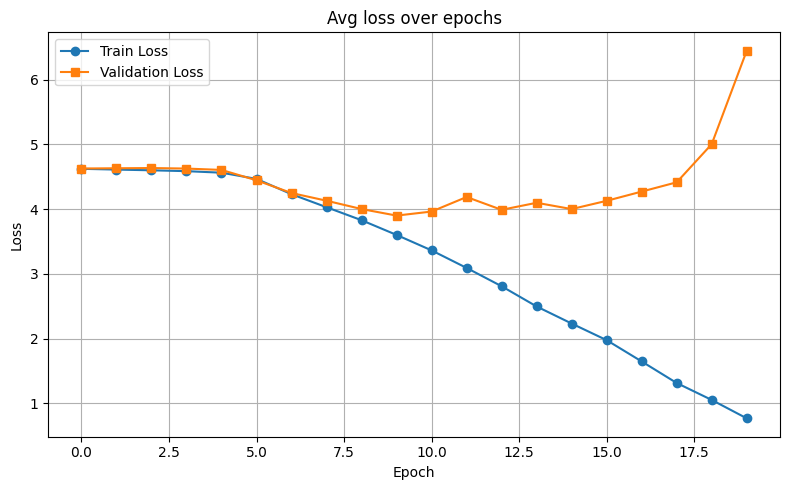

Epoch 1/30 | Train Loss: 4.619785919688106 | Val Loss: 4.62810084399055
Epoch 2/30 | Train Loss: 4.6012065343088056 | Val Loss: 4.639729825188132
Epoch 3/30 | Train Loss: 4.586293278696231 | Val Loss: 4.641683866463455
Epoch 4/30 | Train Loss: 4.572025500611282 | Val Loss: 4.650684670840993
Epoch 5/30 | Train Loss: 4.547167977476431 | Val Loss: 4.622606329824411
Epoch 6/30 | Train Loss: 4.450581357370015 | Val Loss: 4.4521291844985065
Epoch 7/30 | Train Loss: 4.212157322170947 | Val Loss: 4.2969013401106295
Epoch 8/30 | Train Loss: 3.9589673750800505 | Val Loss: 4.084799609464757
Epoch 9/30 | Train Loss: 3.6300535970783443 | Val Loss: 3.75913272932464
Epoch 10/30 | Train Loss: 3.340507750417672 | Val Loss: 3.662914171405867
Epoch 11/30 | Train Loss: 3.048136565680078 | Val Loss: 3.591034103842343
Epoch 12/30 | Train Loss: 2.762464157636389 | Val Loss: 3.5311208332286164
Epoch 13/30 | Train Loss: 2.490742616923546 | Val Loss: 3.8796742308373546
Epoch 14/30 | Train Loss: 2.22485465109997

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▆▇▇▇▇▇██████
train_loss,██████▇▇▆▆▆▅▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▂▂▄▄▅▅▅▆▆▆▇▇▇▇▇▄▇▇██▇███
val_loss,▃▃▃▃▃▃▂▂▁▁▁▁▂▁▂▁▂▂▂▄▅█▅▄▅▄▇▅▅▆
epoch,29
train_acc,100
train_loss,0.00313
val_acc,23.23529
val_loss,6.35344


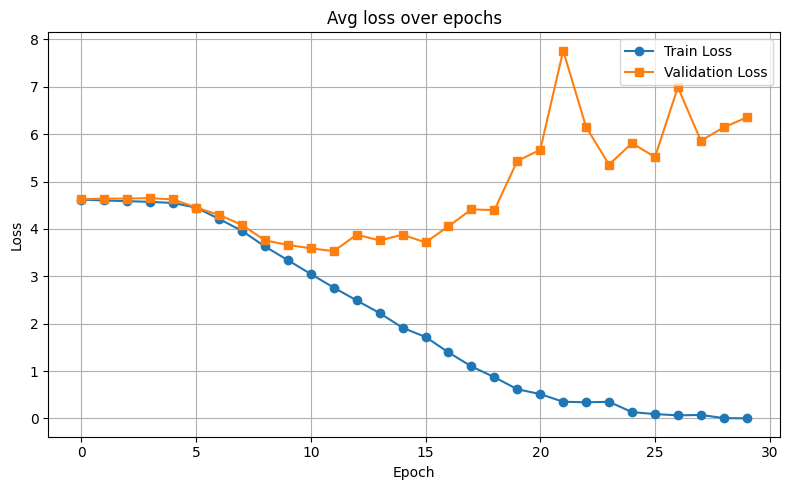

In [ ]:
for train_size in [0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 1.8]:
  train_loader, val_loader, test_loader = load_data(limit_train = train_size)
  model = test_model()
  train_model(model, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-train_impact", run_name = "test_model_" + str(train_size), model_name = "test_model_" + str(train_size))

## Baseline AlexNet

In [ ]:
alexnet = AlexNet()

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 1)

Epoch 1/30 | Train Loss: 4.625406758925494 | Val Loss: 4.625013164445465
Epoch 2/30 | Train Loss: 4.625465871773514 | Val Loss: 4.624999745686849
Epoch 3/30 | Train Loss: 4.625715510050456 | Val Loss: 4.6249869402717145
Epoch 4/30 | Train Loss: 4.62543295691995 | Val Loss: 4.624977201573989
Epoch 5/30 | Train Loss: 4.625419893451766 | Val Loss: 4.62496545829025
Epoch 6/30 | Train Loss: 4.625300800099092 | Val Loss: 4.624955315683402
Epoch 7/30 | Train Loss: 4.625401410869523 | Val Loss: 4.624945229175044
Epoch 8/30 | Train Loss: 4.62533057343726 | Val Loss: 4.624933384914025
Epoch 9/30 | Train Loss: 4.625275421142578 | Val Loss: 4.624920310226141
Epoch 10/30 | Train Loss: 4.625168474982766 | Val Loss: 4.624910175099092
Epoch 11/30 | Train Loss: 4.625439580281576 | Val Loss: 4.6248983420577705
Epoch 12/30 | Train Loss: 4.625045353758569 | Val Loss: 4.624884650286506
Epoch 13/30 | Train Loss: 4.625257963292739 | Val Loss: 4.62486997866163
Epoch 14/30 | Train Loss: 4.6253946042528336 | Va

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▃▃▂▃▄█▃▁▆▅▃▇▃▆▄▃▃▃▄▆▅▂▃▄▇▆▅▅▅▅
train_loss,▆▆█▆▆▅▆▅▅▄▆▃▄▅▄▄▃▅▄▄▅▄▂▅▃▃▂▁▁▃
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▄▅█▇▇▇▄▁▁▁▁▁▁▁▁▇█
val_loss,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▁▁
epoch,29
train_acc,1.07843
train_loss,4.62513
val_acc,1.47059
val_loss,4.62455


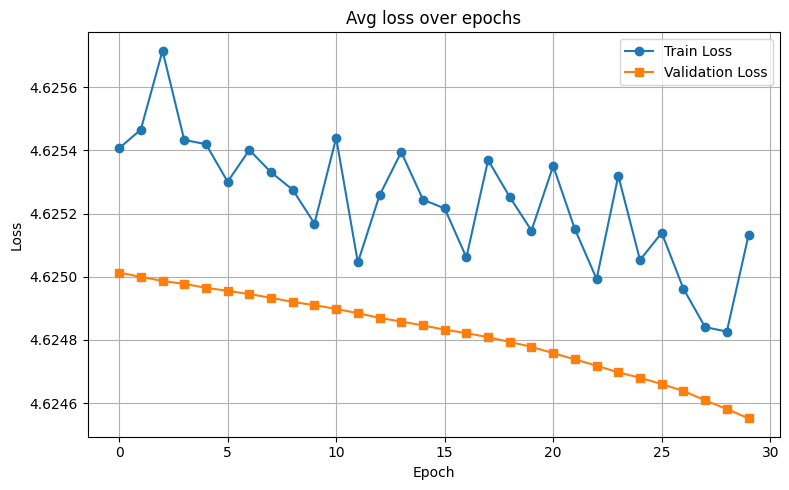

In [ ]:
train_model(alexnet, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-AlexNet", run_name = "AlexNet", model_name = "AlexNet")

## Hyperparameters experiments

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 1)

Epoch 1/30 | Train Loss: 4.630029184678022 | Val Loss: 4.619480297612209
Epoch 2/30 | Train Loss: 4.604549191044826 | Val Loss: 4.568724516326306
Epoch 3/30 | Train Loss: 4.525267054987888 | Val Loss: 4.362137618719363
Epoch 4/30 | Train Loss: 4.507987919975729 | Val Loss: 4.315105329775343
Epoch 5/30 | Train Loss: 4.31117909749349 | Val Loss: 4.248706122005687
Epoch 6/30 | Train Loss: 4.279540978226007 | Val Loss: 4.143571057039149
Epoch 7/30 | Train Loss: 4.010623845867082 | Val Loss: 4.068597097957835
Epoch 8/30 | Train Loss: 4.020449563568714 | Val Loss: 4.276628748575846
Epoch 9/30 | Train Loss: 3.877594166175992 | Val Loss: 4.138514155967563
Epoch 10/30 | Train Loss: 3.5817861444809855 | Val Loss: 4.085300138884899
Epoch 11/30 | Train Loss: 3.626040615754969 | Val Loss: 3.923626589307598
Epoch 12/30 | Train Loss: 3.516156349930109 | Val Loss: 5.067350544649012
Epoch 13/30 | Train Loss: 3.2846337561513863 | Val Loss: 3.9543251318090102
Epoch 14/30 | Train Loss: 3.26296220293232 | 

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_acc,▁▁▁▁▁▁▁▁▂▂▂▂▃▂▃▅▇▇███████
train_loss,█████▇▇▇▇▆▆▆▆▆▅▄▂▂▁▁▁▁▁▁▁
val_acc,▁▁▁▂▃▂▃▃▄▅▅▄▆▅▄▆▅▅▇█▇▇▇██
val_loss,▂▂▂▂▂▁▁▂▁▁▁▃▁▃▇▂▆▆▇▇▇▇███
epoch,24
train_acc,100
train_loss,0.00028
val_acc,14.70588
val_loss,7.97092


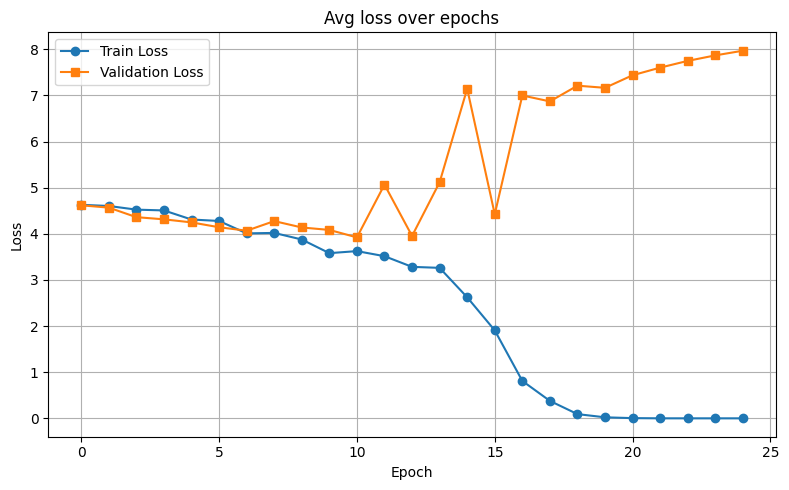

Epoch 1/30 | Train Loss: 4.6300051969640394 | Val Loss: 4.6243562361773325
Epoch 2/30 | Train Loss: 4.6256655188167795 | Val Loss: 4.623578015495749
Epoch 3/30 | Train Loss: 4.624707558575799 | Val Loss: 4.6224072362862385
Epoch 4/30 | Train Loss: 4.622667608074114 | Val Loss: 4.6206116994222
Epoch 5/30 | Train Loss: 4.620856483309876 | Val Loss: 4.617883592493394
Epoch 6/30 | Train Loss: 4.6167338015986426 | Val Loss: 4.613563896627987
Epoch 7/30 | Train Loss: 4.609204138961493 | Val Loss: 4.606635819229425
Epoch 8/30 | Train Loss: 4.599345906575521 | Val Loss: 4.595447166293275
Epoch 9/30 | Train Loss: 4.582098901038076 | Val Loss: 4.571413425370759
Epoch 10/30 | Train Loss: 4.540439164404775 | Val Loss: 4.528443070953967
Epoch 11/30 | Train Loss: 4.45895201365153 | Val Loss: 4.441644548902325
Epoch 12/30 | Train Loss: 4.297875292160931 | Val Loss: 4.276849593368231
Epoch 13/30 | Train Loss: 4.065067287519867 | Val Loss: 4.110642444386202
Epoch 14/30 | Train Loss: 3.7900558883068607 

epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▅▆▆▇█
train_loss,███████████▇▇▆▆▆▅▅▄▃▃▂▂▁
val_acc,▁▁▁▁▁▁▁▁▁▂▃▃▃▃▄▆▅▅▇▇████
val_loss,▃▃▃▃▃▃▃▃▃▃▂▂▁▂▁▁▂▄▁▂▂▃▆█
epoch,23
train_acc,77.7451
train_loss,0.85865
val_acc,12.2549
val_loss,6.14337


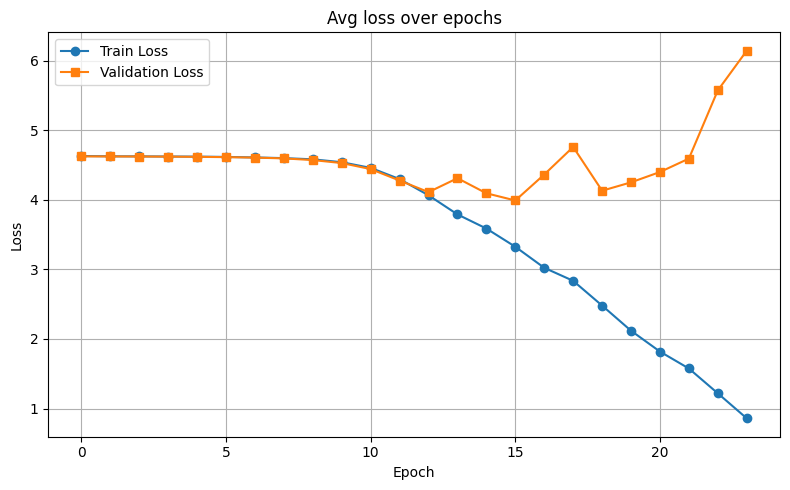

Epoch 1/30 | Train Loss: 4.626292561549766 | Val Loss: 4.6251258663102695
Epoch 2/30 | Train Loss: 4.625396242328718 | Val Loss: 4.624741195229923
Epoch 3/30 | Train Loss: 4.624655506657619 | Val Loss: 4.624332891726026
Epoch 4/30 | Train Loss: 4.624033303354301 | Val Loss: 4.623945823370241
Epoch 5/30 | Train Loss: 4.623336560118432 | Val Loss: 4.623582372478411
Epoch 6/30 | Train Loss: 4.622643395966175 | Val Loss: 4.6231852400536635
Epoch 7/30 | Train Loss: 4.621961085001628 | Val Loss: 4.622767631680357
Epoch 8/30 | Train Loss: 4.621171375349456 | Val Loss: 4.622342094720579
Epoch 9/30 | Train Loss: 4.620412609623927 | Val Loss: 4.621902353623334
Epoch 10/30 | Train Loss: 4.619668100394454 | Val Loss: 4.621430011824065
Epoch 11/30 | Train Loss: 4.6188007354736325 | Val Loss: 4.620904855167164
Epoch 12/30 | Train Loss: 4.617933400472006 | Val Loss: 4.620389654122147
Epoch 13/30 | Train Loss: 4.616953778734394 | Val Loss: 4.6198231566186045
Epoch 14/30 | Train Loss: 4.616014162699382

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▂▂▁▁▂▁▂▁▂▁▂▁▃▂▂▂▃▂▅▆▆▆▇▇▇▆██▇
train_loss,█████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▂▂▁
val_acc,▂▃▂▁▁▁▁▁▁▁▂▁▁▁▂▁▂▅▅▆▆█▇▇▇▆▆▅▅▅
val_loss,█████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▂▂▁
epoch,29
train_acc,2.94118
train_loss,4.58156
val_acc,1.66667
val_loss,4.59814


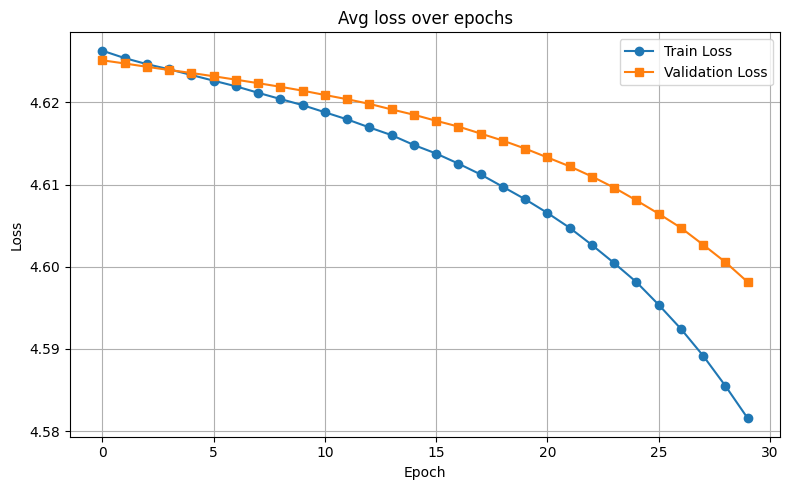

In [ ]:
for lr in [0.1, 0.01, 0.001]:
  model = test_model()
  train_model(model, lr = lr, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-hyperparam-impact", run_name = "Test-lr" + str(lr), model_name = "Test-lr" + str(lr))


Epoch 1/5 | Train Loss: 4.628421701169481 | Val Loss: 4.623897660947313
Epoch 2/5 | Train Loss: 4.624453623154584 | Val Loss: 4.621733175539503
Epoch 3/5 | Train Loss: 4.621699228473738 | Val Loss: 4.617732186410941
Epoch 4/5 | Train Loss: 4.615672698675417 | Val Loss: 4.6108651366888305
Epoch 5/5 | Train Loss: 4.604585561565324 | Val Loss: 4.594697436164407


epoch,▁▃▅▆█
train_acc,▁▂▃▇█
train_loss,█▇▆▄▁
val_acc,▁▂▃▃█
val_loss,█▇▇▅▁
epoch,4
train_acc,2.2549
train_loss,4.60459
val_acc,2.35294
val_loss,4.5947


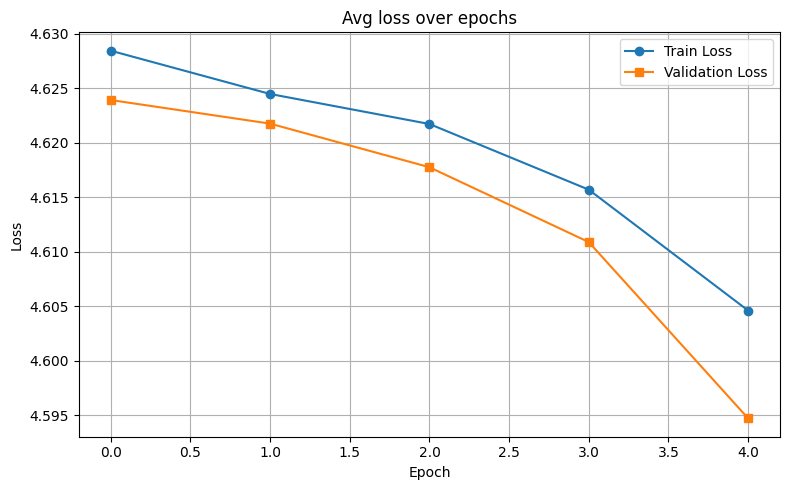

Epoch 1/10 | Train Loss: 4.629080050599342 | Val Loss: 4.6246508617027136
Epoch 2/10 | Train Loss: 4.625928026087144 | Val Loss: 4.624040813072055
Epoch 3/10 | Train Loss: 4.624802873648849 | Val Loss: 4.622735513425341
Epoch 4/10 | Train Loss: 4.622883643356024 | Val Loss: 4.6212457469865384
Epoch 5/10 | Train Loss: 4.620389246473126 | Val Loss: 4.618383213118011
Epoch 6/10 | Train Loss: 4.616941915773878 | Val Loss: 4.613686374589508
Epoch 7/10 | Train Loss: 4.60915802600337 | Val Loss: 4.605078379313151
Epoch 8/10 | Train Loss: 4.595521646387437 | Val Loss: 4.58575013478597
Epoch 9/10 | Train Loss: 4.561900598862592 | Val Loss: 4.531433531817268
Epoch 10/10 | Train Loss: 4.463667222565296 | Val Loss: 4.376447101667815


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▂▃▆▄▆██▇
train_loss,█████▇▇▇▅▁
val_acc,▁▁▁▃▂▁▅▆▇█
val_loss,██████▇▇▅▁
epoch,9
train_acc,2.15686
train_loss,4.46367
val_acc,3.03922
val_loss,4.37645


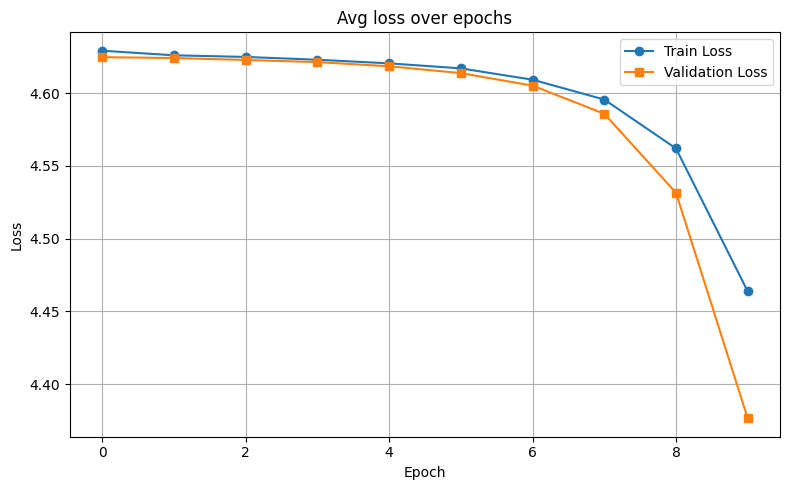

Epoch 1/15 | Train Loss: 4.6290891722136855 | Val Loss: 4.624863430097991
Epoch 2/15 | Train Loss: 4.625828279233446 | Val Loss: 4.623840066498401
Epoch 3/15 | Train Loss: 4.624637611239565 | Val Loss: 4.622345348432952
Epoch 4/15 | Train Loss: 4.622871989829868 | Val Loss: 4.620363942314596
Epoch 5/15 | Train Loss: 4.619408356909658 | Val Loss: 4.616876119725845
Epoch 6/15 | Train Loss: 4.614042491538852 | Val Loss: 4.611445759791954
Epoch 7/15 | Train Loss: 4.605265299479167 | Val Loss: 4.6010666865928505
Epoch 8/15 | Train Loss: 4.588599534128226 | Val Loss: 4.580697145649031
Epoch 9/15 | Train Loss: 4.548847789390415 | Val Loss: 4.526044277116364
Epoch 10/15 | Train Loss: 4.449556874293907 | Val Loss: 4.391431554158529
Epoch 11/15 | Train Loss: 4.236159141390932 | Val Loss: 4.239267569897222
Epoch 12/15 | Train Loss: 4.009812766430425 | Val Loss: 4.108274418699975
Epoch 13/15 | Train Loss: 3.7946529687619677 | Val Loss: 4.019361050923665
Epoch 14/15 | Train Loss: 3.565030079261929 

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▁▁▁▁▁▁▁▂▂▃▃▄▆█
train_loss,█████████▇▆▅▄▂▁
val_acc,▁▁▁▂▂▁▃▃▂▃▃▄▅▇█
val_loss,████████▇▆▄▃▂▁▁
epoch,14
train_acc,18.52941
train_loss,3.28085
val_acc,8.92157
val_loss,3.95166


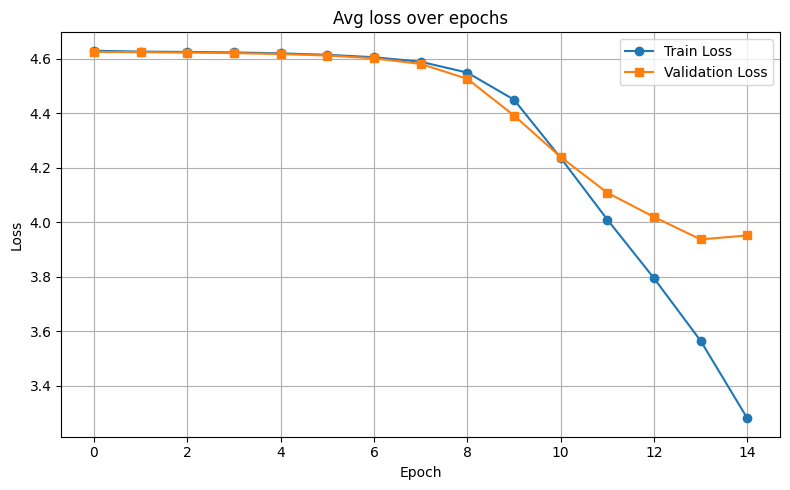

Epoch 1/30 | Train Loss: 4.629555447896322 | Val Loss: 4.624223679187251
Epoch 2/30 | Train Loss: 4.6254611669802195 | Val Loss: 4.622594171411851
Epoch 3/30 | Train Loss: 4.622535047344133 | Val Loss: 4.619445359473135
Epoch 4/30 | Train Loss: 4.618258061128504 | Val Loss: 4.614669081744026
Epoch 5/30 | Train Loss: 4.610208111183316 | Val Loss: 4.6070615282245715
Epoch 6/30 | Train Loss: 4.597704277786554 | Val Loss: 4.592310490327723
Epoch 7/30 | Train Loss: 4.5692017050350415 | Val Loss: 4.5630345737232885
Epoch 8/30 | Train Loss: 4.51049731759464 | Val Loss: 4.503803283093022
Epoch 9/30 | Train Loss: 4.37741865270278 | Val Loss: 4.3067434423110065
Epoch 10/30 | Train Loss: 4.102880006677964 | Val Loss: 4.1444901185877185
Epoch 11/30 | Train Loss: 3.861296141381357 | Val Loss: 4.108683122373095
Epoch 12/30 | Train Loss: 3.655232743655934 | Val Loss: 3.9658440496407303
Epoch 13/30 | Train Loss: 3.363923091514438 | Val Loss: 4.187901104197783
Epoch 14/30 | Train Loss: 3.14765087950463

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▆▇▇▇██████
train_loss,█████████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁
val_acc,▁▁▁▁▂▁▂▂▂▄▄▄▄▅▅▆▅▆▆▇▆█▆▆▆█████
val_loss,▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▃▂▅▃▅▇▇▇▇▇██
epoch,29
train_acc,100
train_loss,0.00306
val_acc,14.60784
val_loss,7.67854


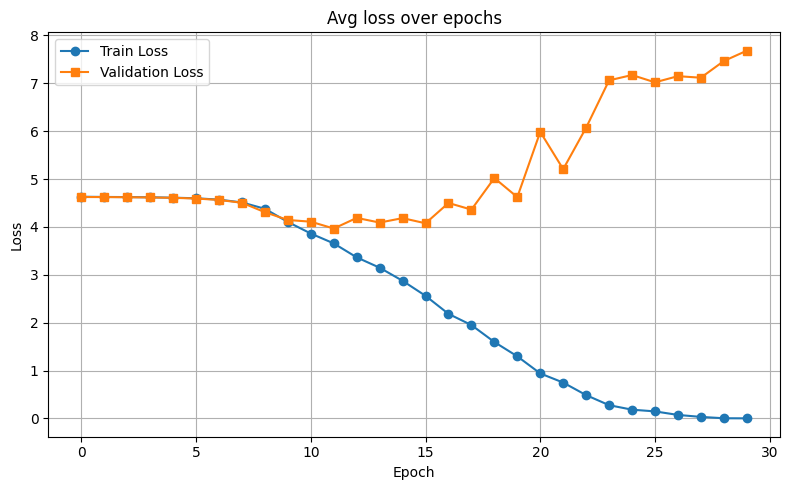

In [ ]:
for epoch in [5, 10, 15, 30]:
  model = test_model()
  train_model(model, epoch = epoch, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-hyperparam-impact", run_name = "Test-epoch" + str(epoch), model_name = "Test-epoch" + str(epoch))


Epoch 1/30 | Train Loss: 9.55906115513222 | Val Loss: 4.626125724642884
Epoch 2/30 | Train Loss: 4.63483087128284 | Val Loss: 4.625637555589863
Epoch 3/30 | Train Loss: 4.634620516907935 | Val Loss: 4.625387289009843
Epoch 4/30 | Train Loss: 4.634019653469909 | Val Loss: 4.625292519962087
Epoch 5/30 | Train Loss: 4.633804470885034 | Val Loss: 4.625234214932311
Epoch 6/30 | Train Loss: 4.634075422847972 | Val Loss: 4.625154603696337
Epoch 7/30 | Train Loss: 4.634363911198634 | Val Loss: 4.625151256486482
Epoch 8/30 | Train Loss: 4.634271902196548 | Val Loss: 4.625123543832816
Epoch 9/30 | Train Loss: 4.633472547344133 | Val Loss: 4.6251127317839975
Epoch 10/30 | Train Loss: 4.634230647367589 | Val Loss: 4.625138911078958
Epoch 11/30 | Train Loss: 4.633889254401712 | Val Loss: 4.6250981947954966
Epoch 12/30 | Train Loss: 4.634077038484461 | Val Loss: 4.625146155263863
Epoch 13/30 | Train Loss: 4.634640779682234 | Val Loss: 4.625104649861654
Epoch 14/30 | Train Loss: 4.634648008907543 | V

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▇▇▃▄▆▃▂▃▇▆▄▂▃▃▂▄▄▄▄▇█▁▆█▆▄▃▃▂▆
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
train_acc,0.4902
train_loss,4.6349
val_acc,0.98039
val_loss,4.62512


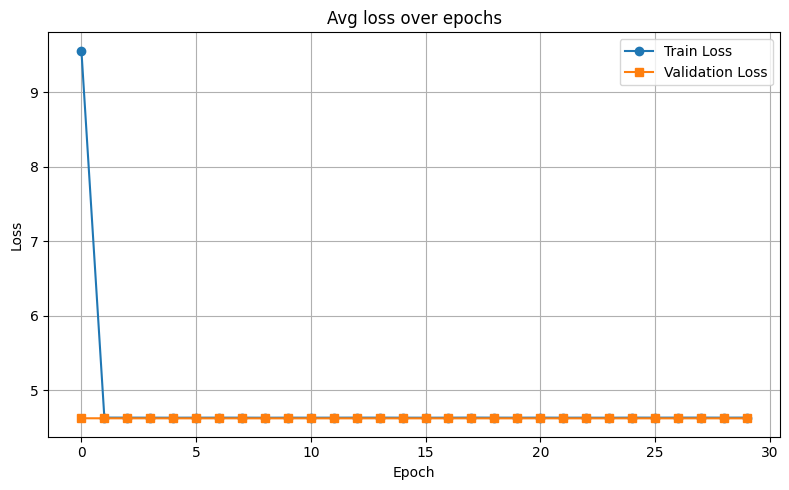

Epoch 1/30 | Train Loss: 4.6284962074429385 | Val Loss: 4.624687628652535
Epoch 2/30 | Train Loss: 4.625741737964106 | Val Loss: 4.623752044228946
Epoch 3/30 | Train Loss: 4.624155123093549 | Val Loss: 4.62239044787837
Epoch 4/30 | Train Loss: 4.62168352837656 | Val Loss: 4.619607674841787
Epoch 5/30 | Train Loss: 4.617874743891697 | Val Loss: 4.615670125624713
Epoch 6/30 | Train Loss: 4.612285023109585 | Val Loss: 4.608696507472618
Epoch 7/30 | Train Loss: 4.6003920873006185 | Val Loss: 4.594095761168237
Epoch 8/30 | Train Loss: 4.576992917528339 | Val Loss: 4.563856842938591
Epoch 9/30 | Train Loss: 4.52261033151664 | Val Loss: 4.49823927785836
Epoch 10/30 | Train Loss: 4.377518384596881 | Val Loss: 4.31497745513916
Epoch 11/30 | Train Loss: 4.1252022238338695 | Val Loss: 4.090087453056785
Epoch 12/30 | Train Loss: 3.8823534086638807 | Val Loss: 4.006033759023629
Epoch 13/30 | Train Loss: 3.6047166599946863 | Val Loss: 4.135723405725816
Epoch 14/30 | Train Loss: 3.365658509497549 | V

In [ ]:
optimize_tests = ["Adam", "SGD"]
for optimizer in optimize_tests:
  model = test_model()
  train_model(model, optimizer = optimizer, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-hyperparam-impact", run_name = "Test-optimizer" + str(optimizer), model_name = "Test-optimizer" + str(optimizer))


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▅▆▆▇▇▇▇██
train_loss,██████████▇▇▆▆▅▅▅▄▃▃▂▂▁▁▂▁▁
val_acc,▁▂▁▂▂▂▂▂▂▂▃▃▃▅▅▇▄▆▇▇█▇▇▇▇██
val_loss,▃▃▃▃▃▃▃▃▂▂▂▂▂▁▂▁▃▂▂▃▃▅▆▅▅▆█
epoch,26
train_acc,97.54902
train_loss,0.11054
val_acc,14.70588
val_loss,6.99281


Epoch 1/30 | Train Loss: 4.628455726773131 | Val Loss: 4.624673282398897
Epoch 2/30 | Train Loss: 4.625996054855047 | Val Loss: 4.623928264543122
Epoch 3/30 | Train Loss: 4.624978488099341 | Val Loss: 4.623130828259038
Epoch 4/30 | Train Loss: 4.623749332801968 | Val Loss: 4.6220738579245175
Epoch 5/30 | Train Loss: 4.622122446695964 | Val Loss: 4.620864494174135
Epoch 6/30 | Train Loss: 4.619890938553156 | Val Loss: 4.6192147198845355
Epoch 7/30 | Train Loss: 4.617546276017731 | Val Loss: 4.616833944881663
Epoch 8/30 | Train Loss: 4.61382365507238 | Val Loss: 4.6136766321518845
Epoch 9/30 | Train Loss: 4.609145549699372 | Val Loss: 4.609277104396446
Epoch 10/30 | Train Loss: 4.602331827201096 | Val Loss: 4.602908594468061
Epoch 11/30 | Train Loss: 4.5919311074649585 | Val Loss: 4.593323920754825
Epoch 12/30 | Train Loss: 4.578021876017252 | Val Loss: 4.577157233743106
Epoch 13/30 | Train Loss: 4.552488895491058 | Val Loss: 4.551121012369792
Epoch 14/30 | Train Loss: 4.508153960284065 

epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▄▄▅▅▆▇▇█
train_loss,███████████████▇▇▆▆▅▅▅▄▄▃▃▂▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▃▄▃▄▅▅▅▅▆▇▇███
val_loss,▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▃▂▂▁▁▂▁▃▃▃▄▅▅█
epoch,28
train_acc,62.7451
train_loss,1.40855
val_acc,10.98039
val_loss,5.04832


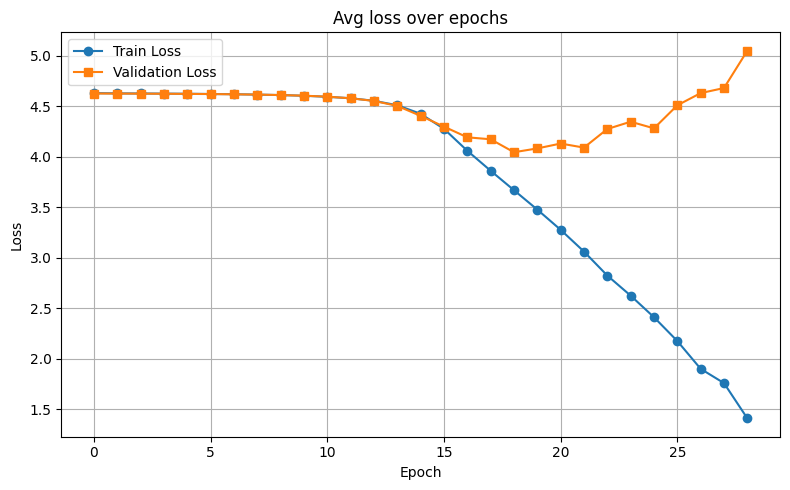

Epoch 1/30 | Train Loss: 4.626807598039216 | Val Loss: 4.624518330891927
Epoch 2/30 | Train Loss: 4.624981659533931 | Val Loss: 4.623719488405714
Epoch 3/30 | Train Loss: 4.623937659170114 | Val Loss: 4.622884204340916
Epoch 4/30 | Train Loss: 4.622635815190334 | Val Loss: 4.622023997587316
Epoch 5/30 | Train Loss: 4.621237332213159 | Val Loss: 4.621050217572381
Epoch 6/30 | Train Loss: 4.619966065649892 | Val Loss: 4.619980666216682
Epoch 7/30 | Train Loss: 4.6181364470837165 | Val Loss: 4.6187662461224726
Epoch 8/30 | Train Loss: 4.61639248717065 | Val Loss: 4.61731705011106
Epoch 9/30 | Train Loss: 4.614082336425781 | Val Loss: 4.615649025112975
Epoch 10/30 | Train Loss: 4.611643862256817 | Val Loss: 4.613651589786305
Epoch 11/30 | Train Loss: 4.6082357369217215 | Val Loss: 4.611325432272518
Epoch 12/30 | Train Loss: 4.604579910577512 | Val Loss: 4.608311282887178
Epoch 13/30 | Train Loss: 4.59997361127068 | Val Loss: 4.60462329340916
Epoch 14/30 | Train Loss: 4.593975830078125 | Va

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▁▁▁▁▁▂▁▁▂▁▂▂▂▂▂▂▂▂▃▂▃▄▃▄▄▄▆▇█
train_loss,██████████████████▇▇▇▇▆▆▅▄▄▂▂▁
val_acc,▁▂▁▂▂▂▁▂▂▂▂▂▃▃▂▃▃▂▃▃▄▅▄▅▆▇▅▅▇█
val_loss,███████████████▇▇▇▇▇▆▆▅▄▃▃▂▂▁▁
epoch,29
train_acc,19.41176
train_loss,3.37337
val_acc,7.7451
val_loss,4.15695


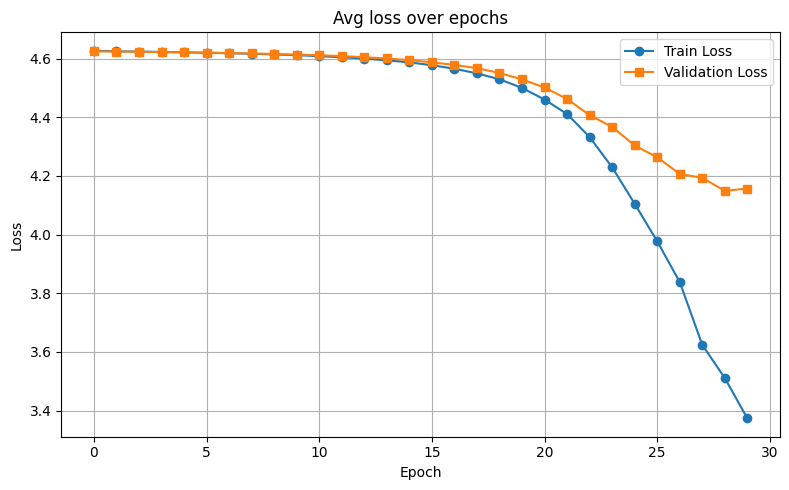

Epoch 1/30 | Train Loss: 4.626362579944087 | Val Loss: 4.62489761651731
Epoch 2/30 | Train Loss: 4.6254559086818325 | Val Loss: 4.624449067957261
Epoch 3/30 | Train Loss: 4.624701047411152 | Val Loss: 4.624013683842677
Epoch 4/30 | Train Loss: 4.623955580767463 | Val Loss: 4.623499133540135
Epoch 5/30 | Train Loss: 4.623221124387255 | Val Loss: 4.623034368776808
Epoch 6/30 | Train Loss: 4.622472845339308 | Val Loss: 4.622488642673867
Epoch 7/30 | Train Loss: 4.621668019014247 | Val Loss: 4.621912997376685
Epoch 8/30 | Train Loss: 4.620915611117494 | Val Loss: 4.621412030388327
Epoch 9/30 | Train Loss: 4.619947186638327 | Val Loss: 4.620776726217831
Epoch 10/30 | Train Loss: 4.619207105449601 | Val Loss: 4.620171819948682
Epoch 11/30 | Train Loss: 4.618058268229166 | Val Loss: 4.619465367934283
Epoch 12/30 | Train Loss: 4.617206528607537 | Val Loss: 4.618753769818475
Epoch 13/30 | Train Loss: 4.61596757477405 | Val Loss: 4.617987958122702
Epoch 14/30 | Train Loss: 4.614876002891391 | Va

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▂▁▂▂▂▃▂▃▅▄▄▄▆▅▆▅▅▆▇█▆▆▅▅▆▆▆▆▇
train_loss,███████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▃▃▂▁
val_acc,▁▁▂▂▂▂▂▃▄▃▄▅▅▇▆▇███▇▆▆▄▄▅▅▅▇▇▆
val_loss,███████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▃▃▂▁
epoch,29
train_acc,4.11765
train_loss,4.55942
val_acc,2.45098
val_loss,4.57788


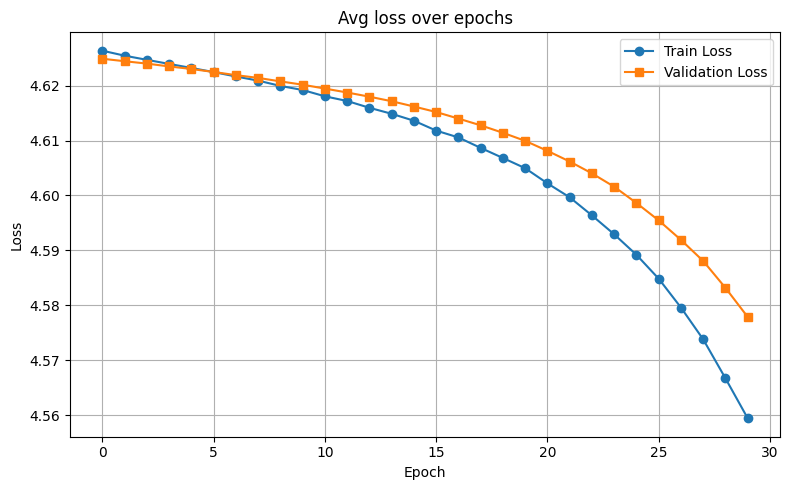

In [ ]:
batch_size_tests = [32, 64, 128]

for batch_size in batch_size_tests:
  train_loader, val_loader, test_loader = load_data(limit_train = 1, batch_size=batch_size)
  model = test_model()
  train_model(model, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-hyperparam-impact", run_name = "Test-batch_size" + str(batch_size), model_name = "Test-batch_size" + str(batch_size))


## Batch norm and Dropout

Epoch 1/30 | Train Loss: 4.634732455833285 | Val Loss: 4.62454714307598
Epoch 2/30 | Train Loss: 4.62621078117221 | Val Loss: 4.623467441633636
Epoch 3/30 | Train Loss: 4.624126845715093 | Val Loss: 4.621604706259335
Epoch 4/30 | Train Loss: 4.616963427674537 | Val Loss: 4.617060511719947
Epoch 5/30 | Train Loss: 4.612361754623114 | Val Loss: 4.610727560753916
Epoch 6/30 | Train Loss: 4.598355708402746 | Val Loss: 4.597851622338388
Epoch 7/30 | Train Loss: 4.571423369762944 | Val Loss: 4.565528660194547
Epoch 8/30 | Train Loss: 4.501605060053807 | Val Loss: 4.490939802281996
Epoch 9/30 | Train Loss: 4.389683996462354 | Val Loss: 4.346669391557282
Epoch 10/30 | Train Loss: 4.238442495757458 | Val Loss: 4.207968928767186
Epoch 11/30 | Train Loss: 4.106090538174498 | Val Loss: 4.14416732414096
Epoch 12/30 | Train Loss: 3.995502707537483 | Val Loss: 4.086739742054659
Epoch 13/30 | Train Loss: 3.847624195323271 | Val Loss: 4.062540267495548
Epoch 14/30 | Train Loss: 3.7185385909734987 | Val

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▆▆▇▇▇███
train_loss,█████████▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁
val_acc,▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▆▅▇▇▆█▇▇█▆▇▆▇▆▇
val_loss,▆▆▆▆▆▆▅▅▄▃▃▂▂▂▂▁▁▁▂▃▂▃▄▃▅██▆█▇
epoch,29
train_acc,71.66667
train_loss,1.12618
val_acc,10.98039
val_loss,4.83399


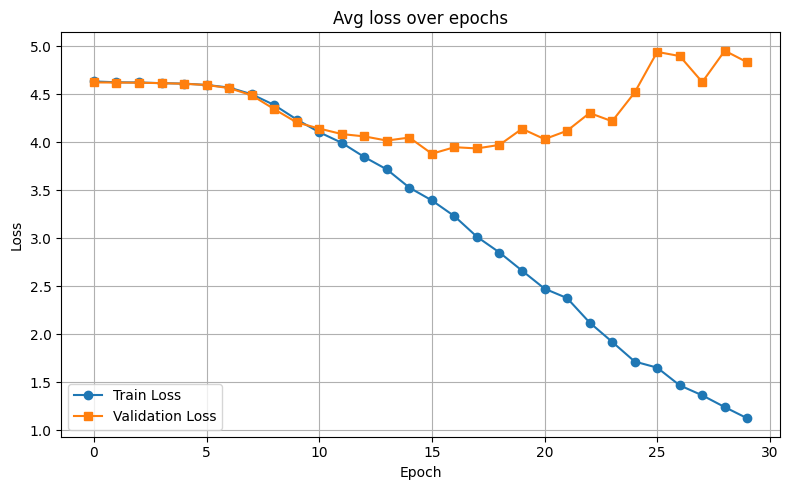

Epoch 1/30 | Train Loss: 4.640933616488588 | Val Loss: 4.624933018403895
Epoch 2/30 | Train Loss: 4.627564104865579 | Val Loss: 4.624616974475337
Epoch 3/30 | Train Loss: 4.6253715589934705 | Val Loss: 4.623447257397221
Epoch 4/30 | Train Loss: 4.620774224225213 | Val Loss: 4.621876439861222
Epoch 5/30 | Train Loss: 4.618119999006683 | Val Loss: 4.619618243797152
Epoch 6/30 | Train Loss: 4.608470374462652 | Val Loss: 4.614329293194939
Epoch 7/30 | Train Loss: 4.59143944160611 | Val Loss: 4.602356095407523
Epoch 8/30 | Train Loss: 4.551108337851131 | Val Loss: 4.563919381534352
Epoch 9/30 | Train Loss: 4.456037951450722 | Val Loss: 4.457778392118566
Epoch 10/30 | Train Loss: 4.337605629715265 | Val Loss: 4.344032953299728
Epoch 11/30 | Train Loss: 4.191484103483313 | Val Loss: 4.227407193651386
Epoch 12/30 | Train Loss: 4.04120101554721 | Val Loss: 4.168274830836876
Epoch 13/30 | Train Loss: 3.938145544014725 | Val Loss: 4.094648738935882
Epoch 14/30 | Train Loss: 3.7819561042037666 | V

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇▇██
train_loss,█████████▇▇▇▇▆▆▅▅▅▅▄▄▃▃▃▃▂▂▂▁▁
val_acc,▁▁▁▁▂▂▂▂▂▃▃▄▅▄▅▅▅▆▆▆▇▇▆▇▆▅▇█▆▆
val_loss,▇▇▇▇▇▆▆▆▅▄▄▃▃▂▂▁▁▁▁▂▁▁▂▂▄▇▄▄▆█
epoch,29
train_acc,68.52941
train_loss,1.29209
val_acc,8.43137
val_loss,4.81545


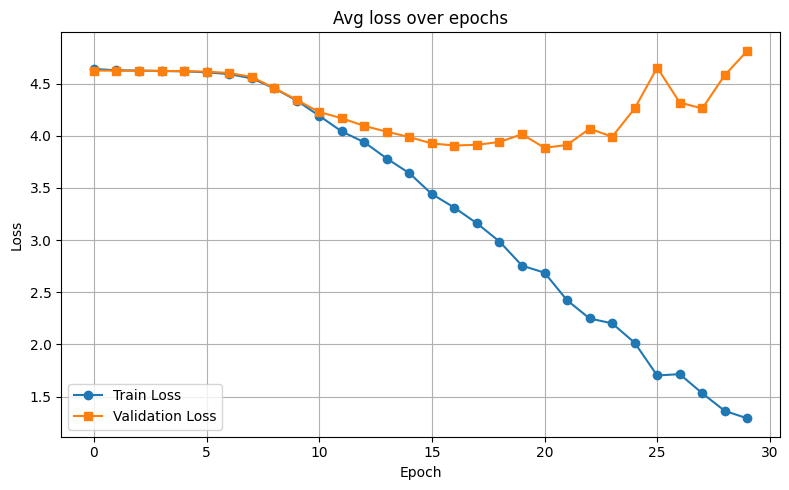

Epoch 1/30 | Train Loss: 4.657331975301107 | Val Loss: 4.6248655020021925
Epoch 2/30 | Train Loss: 4.628408682580088 | Val Loss: 4.6248789693795
Epoch 3/30 | Train Loss: 4.624746707841462 | Val Loss: 4.623970727359548
Epoch 4/30 | Train Loss: 4.618363141078575 | Val Loss: 4.623413388869341
Epoch 5/30 | Train Loss: 4.612515722536573 | Val Loss: 4.620868409848681
Epoch 6/30 | Train Loss: 4.6034122953227925 | Val Loss: 4.617514475654153
Epoch 7/30 | Train Loss: 4.58287971720976 | Val Loss: 4.610723948011211
Epoch 8/30 | Train Loss: 4.546193362217323 | Val Loss: 4.598016761330998
Epoch 9/30 | Train Loss: 4.499268382203345 | Val Loss: 4.575188879873238
Epoch 10/30 | Train Loss: 4.447582858216529 | Val Loss: 4.545860425163718
Epoch 11/30 | Train Loss: 4.373780976089777 | Val Loss: 4.4895936891144395
Epoch 12/30 | Train Loss: 4.2356517754349055 | Val Loss: 4.393279973198386
Epoch 13/30 | Train Loss: 4.060207011652928 | Val Loss: 4.277984783696193
Epoch 14/30 | Train Loss: 3.9418382420259364 |

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇█
train_loss,█████████▇▇▇▆▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▁▁
val_acc,▁▁▁▁▁▂▂▂▃▃▃▃▃▅▅▅▆▇▅▅▇▆▇▇▇▆█▇▇▆
val_loss,████████▇▇▇▆▅▄▃▃▂▂▁▂▁▂▁▂▂▂▁▂▂▄
epoch,29
train_acc,52.64706
train_loss,1.96098
val_acc,7.54902
val_loss,4.18096


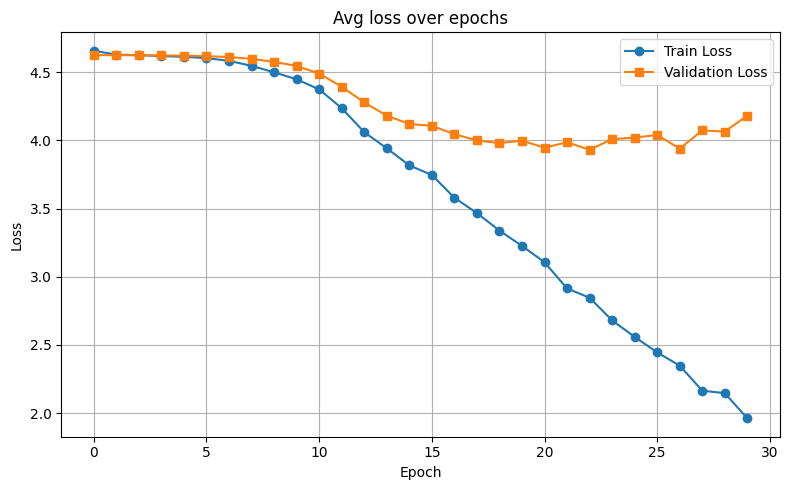

Epoch 1/30 | Train Loss: 4.633201412126129 | Val Loss: 4.624945610644771
Epoch 2/30 | Train Loss: 4.627210691863415 | Val Loss: 4.624201501584521
Epoch 3/30 | Train Loss: 4.62554994096943 | Val Loss: 4.623251264235552
Epoch 4/30 | Train Loss: 4.622759373982747 | Val Loss: 4.621728160334569
Epoch 5/30 | Train Loss: 4.61711296006745 | Val Loss: 4.6193899715647975
Epoch 6/30 | Train Loss: 4.613091420192345 | Val Loss: 4.614766932468788
Epoch 7/30 | Train Loss: 4.6027269999186196 | Val Loss: 4.603706326204188
Epoch 8/30 | Train Loss: 4.579533337611778 | Val Loss: 4.577916605332319
Epoch 9/30 | Train Loss: 4.527069177814559 | Val Loss: 4.506076618269378
Epoch 10/30 | Train Loss: 4.386599869821586 | Val Loss: 4.350607008092544
Epoch 11/30 | Train Loss: 4.2214081969915656 | Val Loss: 4.226883278641046
Epoch 12/30 | Train Loss: 4.12304053961062 | Val Loss: 4.151910033880496
Epoch 13/30 | Train Loss: 3.9460635690128103 | Val Loss: 4.060129270366594
Epoch 14/30 | Train Loss: 3.8061467750399722 |

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▆▆▇▇▇███
train_loss,██████████▇▇▇▆▆▆▅▅▅▄▄▃▃▂▂▂▂▁▁▁
val_acc,▁▁▁▁▂▂▂▂▂▂▂▂▃▄▅▅▆▅▆▇▇▇▆▇█▇▆▇▇█
val_loss,████████▇▆▅▅▄▃▃▃▂▂▁▁▁▁▃▂▂▄▆▇▇▆
epoch,29
train_acc,75.09804
train_loss,1.01032
val_acc,15.78431
val_loss,4.29334


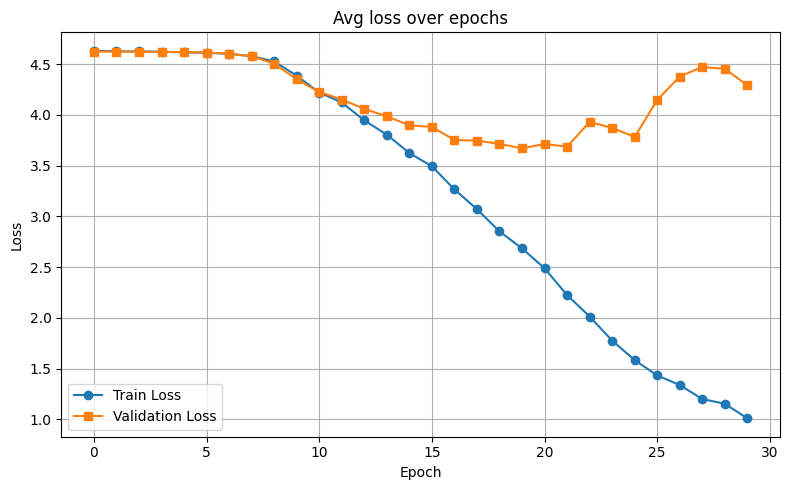

Epoch 1/30 | Train Loss: 4.644340200985179 | Val Loss: 4.625263819975012
Epoch 2/30 | Train Loss: 4.62766955132578 | Val Loss: 4.6248271343754785
Epoch 3/30 | Train Loss: 4.627256868399826 | Val Loss: 4.624346729353363
Epoch 4/30 | Train Loss: 4.621864775115369 | Val Loss: 4.623398036582797
Epoch 5/30 | Train Loss: 4.618880634681851 | Val Loss: 4.622148536233341
Epoch 6/30 | Train Loss: 4.612038118699018 | Val Loss: 4.619322324266621
Epoch 7/30 | Train Loss: 4.606459191266228 | Val Loss: 4.613540959825703
Epoch 8/30 | Train Loss: 4.591132586610083 | Val Loss: 4.604525308048024
Epoch 9/30 | Train Loss: 4.572404154609232 | Val Loss: 4.589232141831342
Epoch 10/30 | Train Loss: 4.513067993463254 | Val Loss: 4.533278480230593
Epoch 11/30 | Train Loss: 4.411959958543965 | Val Loss: 4.426613601983762
Epoch 12/30 | Train Loss: 4.275248692082424 | Val Loss: 4.2924206640206135
Epoch 13/30 | Train Loss: 4.1218284270342656 | Val Loss: 4.183421340643191
Epoch 14/30 | Train Loss: 4.030865407457538 |

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▅▆▆▇▇██
train_loss,██████████▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
val_acc,▁▁▁▁▁▁▂▁▂▂▂▃▃▄▄▄▄▄▆▅▅▆▆▆▆▇▇▇▇█
val_loss,█████████▇▇▆▅▄▄▄▃▃▂▂▂▁▁▁▂▁▁▂▄▃
epoch,29
train_acc,54.70588
train_loss,1.80132
val_acc,15.29412
val_loss,3.88227


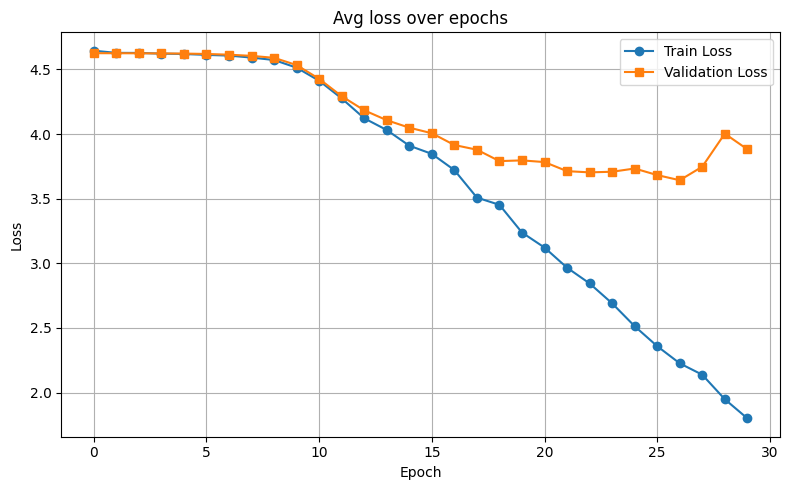

Epoch 1/30 | Train Loss: 4.65267988466749 | Val Loss: 4.62531909568637
Epoch 2/30 | Train Loss: 4.629920697679706 | Val Loss: 4.625322790706859
Epoch 3/30 | Train Loss: 4.62639425315109 | Val Loss: 4.625266849293428
Epoch 4/30 | Train Loss: 4.624906678293265 | Val Loss: 4.624929345822801
Epoch 5/30 | Train Loss: 4.623663389916514 | Val Loss: 4.624423524445178
Epoch 6/30 | Train Loss: 4.620657711403043 | Val Loss: 4.624053483850815
Epoch 7/30 | Train Loss: 4.615304804783241 | Val Loss: 4.6223712921142575
Epoch 8/30 | Train Loss: 4.6054363587323355 | Val Loss: 4.619950844259823
Epoch 9/30 | Train Loss: 4.593774642196356 | Val Loss: 4.614168604682473
Epoch 10/30 | Train Loss: 4.566749524135216 | Val Loss: 4.600354116103229
Epoch 11/30 | Train Loss: 4.531630014905742 | Val Loss: 4.583901708266314
Epoch 12/30 | Train Loss: 4.488545462664436 | Val Loss: 4.54683645659802
Epoch 13/30 | Train Loss: 4.454966399248908 | Val Loss: 4.530627041237027
Epoch 14/30 | Train Loss: 4.423423250983743 | Val

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_acc,▁▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▆▆██
train_loss,██████████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▁▁
val_acc,▁▁▁▁▁▂▂▂▂▃▂▂▂▂▂▃▃▃▄▄▄▄▅▆▆▇▇██▇
val_loss,███████████▇▇▇▇▇▆▅▅▅▅▄▄▃▃▃▂▂▁▁
epoch,29
train_acc,20.98039
train_loss,3.25166
val_acc,10.68627
val_loss,3.83349


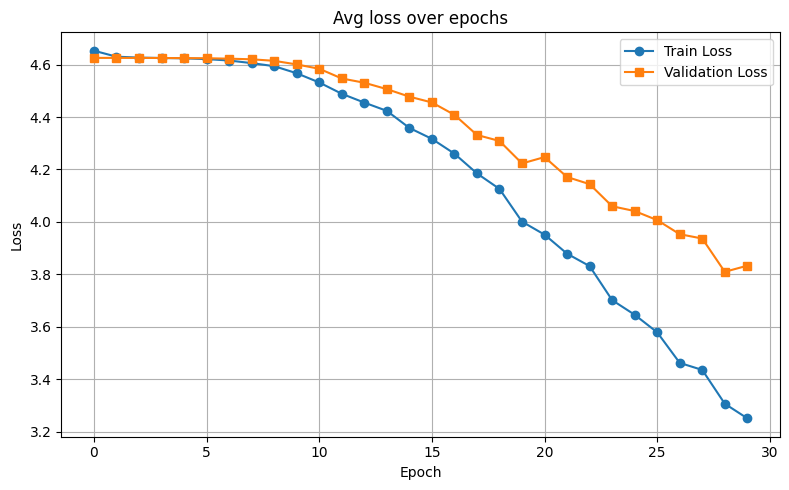

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 1)

test_model = lambda dropout_cnn, dropout_dense, batch_norm: CNN(3, [3,3,3], [3, 32, 64, 128], 2, [128*28*28, 256, 102], dropout_cnn=dropout_cnn, dropout_dense=dropout_dense)

for dropout_cnn, dropout_dense, batch_norm in [(0.2, 0.1, False), (0.4, 0.1, False), (0.6, 0.1, False) ,(0.2, 0.1, True), (0.4, 0.1, True), (0.6, 0.1, True)]:
  dropout_cnn_all = [dropout_cnn] * 3
  dropout_dense_all = [dropout_dense] * 2
  model = test_model(dropout_cnn_all, dropout_dense_all,batch_norm )
  name =  "Test-drop_cnn" + str(dropout_cnn) + "-drop_dense-" + str(dropout_dense) + "-norm-" + str(batch_norm)
  train_model(model, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-hyperparam-impact", run_name = name , model_name = name)



## Data augmentation


Epoch 1/30 | Train Loss: 4.642859455183441 | Val Loss: 4.624949788112266
Epoch 2/30 | Train Loss: 4.62816177442962 | Val Loss: 4.62477341446222
Epoch 3/30 | Train Loss: 4.622026095670813 | Val Loss: 4.623571624007879
Epoch 4/30 | Train Loss: 4.618678242552514 | Val Loss: 4.621930627261891
Epoch 5/30 | Train Loss: 4.612828243480009 | Val Loss: 4.619528063605814
Epoch 6/30 | Train Loss: 4.603135726031135 | Val Loss: 4.614230630912033
Epoch 7/30 | Train Loss: 4.587307155833525 | Val Loss: 4.603146893370385
Epoch 8/30 | Train Loss: 4.557555912990196 | Val Loss: 4.582377186943503
Epoch 9/30 | Train Loss: 4.511379376579733 | Val Loss: 4.5594382678761205
Epoch 10/30 | Train Loss: 4.4590195898916205 | Val Loss: 4.518005958257937
Epoch 11/30 | Train Loss: 4.383872768925685 | Val Loss: 4.471307215971105
Epoch 12/30 | Train Loss: 4.284515104106828 | Val Loss: 4.430855418186562
Epoch 13/30 | Train Loss: 4.167651359707701 | Val Loss: 4.383269377315746
Epoch 14/30 | Train Loss: 4.068030802408854 | V

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train_acc,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▅▅▆▆▆▇▇█
train_loss,██████████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁
val_acc,▁▁▁▁▁▂▁▂▂▂▂▃▃▄▃▅▅▆▆▅▆█▆██▆█▇
val_loss,█████████▇▇▇▆▅▅▄▄▄▃▃▂▂▂▁▂▃▃▄
epoch,27
train_acc,59.01961
train_loss,1.65979
val_acc,12.05882
val_loss,4.06231


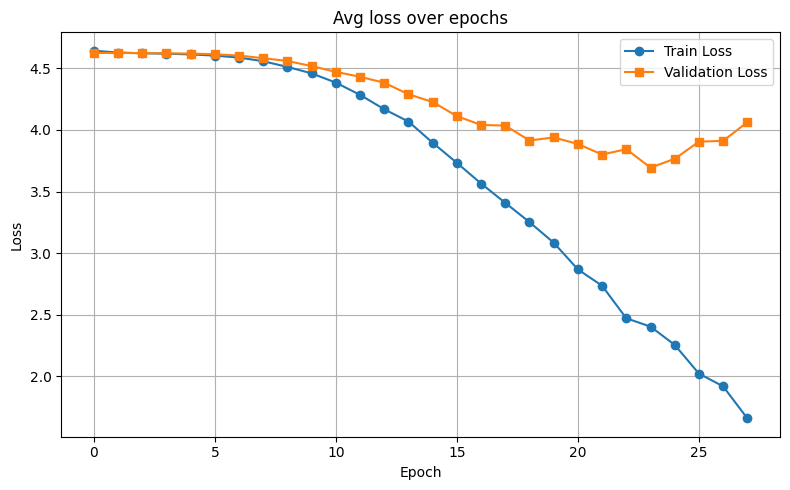

Epoch 1/30 | Train Loss: 4.638831194709329 | Val Loss: 4.6244282030591775
Epoch 2/30 | Train Loss: 4.6310395857867075 | Val Loss: 4.623631189383713
Epoch 3/30 | Train Loss: 4.6274319405649225 | Val Loss: 4.622705612930597
Epoch 4/30 | Train Loss: 4.620650145586799 | Val Loss: 4.620283904730105
Epoch 5/30 | Train Loss: 4.612630208333333 | Val Loss: 4.615067971921435
Epoch 6/30 | Train Loss: 4.597898232703115 | Val Loss: 4.602146014045267
Epoch 7/30 | Train Loss: 4.563713253245634 | Val Loss: 4.5673742443907495
Epoch 8/30 | Train Loss: 4.4854868234372605 | Val Loss: 4.4753237032422835
Epoch 9/30 | Train Loss: 4.382527549594056 | Val Loss: 4.372916816262638
Epoch 10/30 | Train Loss: 4.290023048251283 | Val Loss: 4.29500129924101
Epoch 11/30 | Train Loss: 4.203862754971373 | Val Loss: 4.255631084068149
Epoch 12/30 | Train Loss: 4.1934629589903585 | Val Loss: 4.196248798744351
Epoch 13/30 | Train Loss: 4.113355958228018 | Val Loss: 4.178793110566981
Epoch 14/30 | Train Loss: 4.0232655843098

In [ ]:
train_loader, val_loader, test_loader = load_data(limit_train = 1)
model = test_model([0.4,0.4,0.4], [0.1,0.1], False)
name = "Test-augmentation-false"
train_model(model, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-hyperparam-impact", run_name = name , model_name = name)

train_loader, val_loader, test_loader = load_data(limit_train = 1, augmentation = True)
model = test_model([0.4,0.4,0.4], [0.1,0.1], True)
name = "Test-augmentation-true"
train_model(model, train_loader=train_loader, val_loader=val_loader, project_name = "Flowers102-hyperparam-impact", run_name = name , model_name = name)

